In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import LinearSVC
import torch
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from pickle import dump, load
import joblib

import re
from scipy import sparse
from sentence_transformers import SentenceTransformer
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


### Data (1)

The tab below retrieves  all the data that will be relevant for building the traditional classifiers.

set the variables  `PAIRED_PATH` and  `UNPAIRED_PATH` appropriatly

In [2]:

# path = f'hidden_states/paired_testset_embeddings_{0}-{50}.csv'
# df = pd.read_csv(path, index_col=0)
# for i in range(50, 500, 50):
#     path = f'hidden_states/paired_testset_embeddings_{i}-{i+50}.csv'
#     temp = pd.read_csv(path)
#     df = pd.concat([df, temp])



PAIRED_PATH = './dataset/paired_testset.csv'
UNPAIRED_PATH = './dataset/testset.csv'
paired = pd.read_csv(PAIRED_PATH, index_col=0)

testset = pd.read_csv(UNPAIRED_PATH, index_col=0)
testset.set_index('file_name', inplace=True) 

testset


,prompt,completion,brief_type,data_type,file_path
file_name,,,,,
gov.uscourts.cand.34465.288.0.txt,"CLRB Hanson Industries, LLC et al v. Google In...",deny,opposition,train,456
gov.uscourts.cand.34465.234.0.txt,"CLRB Hanson Industries, LLC et al v. Google In...",deny,support,train,456
gov.uscourts.cand.203194.41.0.txt,Case 4:08-cv-02364-CW\n\n1\n2\n3\n4\n5\n6\n7\n...,TBD,opposition,test,688
gov.uscourts.cand.203194.38.0.txt,Case 4:08-cv-02364-CW\n1\n2\n3\n4\n5\n6\n7\n8\...,TBD,support,test,688
gov.uscourts.vawd.109120.162.0.txt,UNITED STATES DISTRICT COURT\nFOR THE WESTERN ...,grant,opposition,train,1178
...,...,...,...,...,...
gov.uscourts.casd.256908.58.0.txt,Case 3:07-cv-02000-H-CAB\n\n1\n2\n3\n\nDocumen...,deny,support,train,892
gov.uscourts.cacd.470923.66.0.txt,Case 2:10-cv-03113-R -RC Document 66\n\nFiled ...,TBD,opposition,test,947
gov.uscourts.cacd.470923.65.0.txt,Case 2:10-cv-03113-R -RC Document 65\n\nFiled ...,TBD,support,test,947


In [3]:
paired[paired["data_type"]=="train"].shape, paired[paired["data_type"]=="test"].shape , paired.shape



((675, 8), (500, 8), (1175, 8))

In [4]:
testset[testset["data_type"] == "train"].shape

(1646, 5)

In [109]:
truth = pd.read_csv('./dataset/gold.csv', header=None) 
truth.columns =  ["folder_id", "brief", "type", "target"]

# find rows in testset where testset['file_name'] == truth['brief']
# and add the target to testset

truth.set_index('brief', inplace=True)

paired_truth = truth.groupby('folder_id').agg({'target': 'first'})

paired_truth

paired = paired.join(paired_truth, on='folder_id', how='left')
paired["outcome"] = paired[["outcome","target"]].apply(lambda x: x[1].strip() if 'TBD' in x[0] else x[0].strip(), axis=1)
paired

/tmp/ipykernel_4714/2001083846.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  paired["outcome"] = paired[["outcome","target"]].apply(lambda x: x[1].strip() if 'TBD' in x[0] else x[0].strip(), axis=1)


,support,support_file,opposition,opposition_file,outcome,folder_id,case_path,data_type,target
0,"['CLRB Hanson Industries, LLC et al v. Google ...",['gov.uscourts.cand.34465.234.0.txt'],"['CLRB Hanson Industries, LLC et al v. Google ...",['gov.uscourts.cand.34465.288.0.txt'],deny,456,/mnt/a536sing/sdr1/gvc-recap/5/gov.uscourts.ca...,train,NaN
1,['Case 4:08-cv-02364-CW\n1\n2\n3\n4\n5\n6\n7\n...,['gov.uscourts.cand.203194.38.0.txt'],['Case 4:08-cv-02364-CW\n\n1\n2\n3\n4\n5\n6\n7...,['gov.uscourts.cand.203194.41.0.txt'],grant,688,/mnt/a536sing/sdc1/gvc-recap/4/gov.uscourts.ca...,test,grant
2,['UNITED STATES DISTRICT COURT\nFOR THE WESTER...,['gov.uscourts.vawd.109120.98.0.txt'],['UNITED STATES DISTRICT COURT\nFOR THE WESTER...,['gov.uscourts.vawd.109120.162.0.txt'],grant,1178,/mnt/a536sing/sdo1/gvc-recap/0/gov.uscourts.va...,train,NaN
3,"[', Case 1:08-0v-00|96-RBW Document 7 Filed 07...",['gov.uscourts.dcd.129531.7.0.txt'],['Case 1:08-cv-00196-RBW\n\nDocument 8\n\nFile...,['gov.uscourts.dcd.129531.8.0.txt'],deny,997,/mnt/a536sing/sdx1/gvc-recap/1/gov.uscourts.dc...,test,deny
4,['Case 1:08-cv-06978-TPG Document 586 Filed 07...,"['gov.uscourts.nysd.330523.586.0.txt', 'gov.us...",['Case 1:08-cv-06978-TPG Document 591 Filed 07...,['gov.uscourts.nysd.330523.591.0.txt'],deny,895,/mnt/a536sing/sdr1/gvc-recap/3/gov.uscourts.ny...,train,NaN
...,...,...,...,...,...,...,...,...,...
1170,"[""..\nCLERK'S OFFICE U.S. DIST. COURT\nAT ROAN...",['gov.uscourts.vawd.108351.5.0.txt'],['IN THE UNITED STATES DISTRICT COURT\nFOR THE...,['gov.uscourts.vawd.108351.10.0.txt'],grant,815,/mnt/a536sing/sdah1/gvc-recap/1/gov.uscourts.v...,train,NaN
1171,['Case3:08-cv-00484-JSW Document295\n\n1\n2\n3...,['gov.uscourts.cand.199646.295.0.txt'],['Case3:08-cv-00484-JSW Document306\n\n1\n2\n3...,['gov.uscourts.cand.199646.306.0.txt'],grant,568,/mnt/a536sing/sdn1/gvc-recap/6/gov.uscourts.ca...,test,grant
1172,['Case 3:07-cv-02000-H-CAB\n\n1\n2\n3\n\nDocum...,['gov.uscourts.casd.256908.58.0.txt'],['Case 3:07-cv-02000-H-CAB\n\n1\n2\n3\n4\n5\n6...,"['gov.uscourts.casd.256908.95.0.txt', 'gov.usc...",deny,892,/mnt/a536sing/sdt1/gvc-recap/8/gov.uscourts.ca...,train,NaN
1173,['Case 2:10-cv-03113-R -RC Document 65\n\nFile...,['gov.uscourts.cacd.470923.65.0.txt'],"[""Case 2:10-cv-03113-R -RC Document 66\n\nFile...",['gov.uscourts.cacd.470923.66.0.txt'],deny,947,/mnt/a536sing/sdc1/gvc-recap/3/gov.uscourts.ca...,test,deny


In [70]:
# testset[truth['brief'].isin(testset['file_name'])]

joined = testset.join(truth, how='outer')
joined["completion"] = joined[["completion", "target"]].apply(lambda x: x[1].strip() if 'TBD' in x[0] else x[0].strip(), axis=1)

joined = joined.drop(columns=['target', 'folder_id', 'type'])
joined

/tmp/ipykernel_4714/1143000415.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  joined["completion"] = joined[["completion", "target"]].apply(lambda x: x[1].strip() if 'TBD' in x[0] else x[0].strip(), axis=1)


,prompt,completion,brief_type,data_type,file_path
gov.uscourts.akd.243.198.0.txt,Case 3:05-cv-00006-HRH\n\nDocument 198\n\nFile...,grant,support,train,366
gov.uscourts.akd.243.201.0.txt,Case 3:05-cv-00006-HRH Document 201 Filed 07/0...,grant,opposition,train,366
gov.uscourts.akd.243.37.0.txt,Case 3:05-cv-00006-HRH\n\nDocument 37\n\nFiled...,grant,support,train,674
gov.uscourts.akd.243.40.0.txt,Case 3:05-cv-00006-HRH\n\nDocument 40\n\nFiled...,grant,support,train,674
gov.uscourts.akd.243.46.0.txt,Case 3:05-cv-00006-HRH\n\nDocument 46\n\nFiled...,grant,opposition,train,674
...,...,...,...,...,...
gov.uscourts.wyd.32018.10.0.txt,Case 2:15-cv-00064-SWS Document 10 Filed 05/13...,deny,opposition,train,1118
gov.uscourts.wyd.32018.13.0.txt,Case 2:15-cv-00064-SWS Document 13 Filed 06/08...,grant,support,train,113
gov.uscourts.wyd.32018.15.0.txt,Case 2:15-cv-00064-SWS Document 15 Filed 06/23...,grant,opposition,train,113
gov.uscourts.wyd.32018.18.0.txt,Case 2:15-cv-00064-SWS Document 18 Filed 07/14...,grant,opposition,train,113


In [90]:
complets = joined.groupby('file_path').apply(lambda x: x['completion'][0])
complets = complets.reset_index()
complets.columns = ['file_path', 'completion']
complets

/tmp/ipykernel_4714/621605928.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  complets = joined.groupby('file_path').apply(lambda x: x['completion'][0])
/tmp/ipykernel_4714/621605928.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  complets = joined.groupby('file_path').apply(lambda x: x['completion'][0])


,file_path,completion
0,1,grant
1,2,deny
2,3,deny
3,4,deny
4,5,deny
...,...,...
1170,1179,grant
1171,1180,grant
1172,1181,grant
1173,1182,deny


In [91]:
complets[complets["completion"] == 'grant'].shape , complets[complets["completion"] == 'deny'].shape

((554, 2), (621, 2))

### Functions (2)

This tab contains the definition and configuration of the traditional classifiers.

It also contains some utility functions. The most relevant one is 
`accuracies(trainX, trainY, testX, testY, models=models, feature_type='')`

This function takes a model aswell as pairwise data points. The function trains, saves and reports the perfomance of the model.

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf1 = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)

clf2 = RandomForestClassifier(n_estimators = 1500, criterion = "entropy", oob_score = True, max_features= 1)

clf3 = KNeighborsClassifier( n_neighbors=2)

clf4 = LogisticRegression(solver='liblinear')

clf5 = LinearSVC( random_state=42, tol=1e-5)

models = {
    "SGD": clf1,
    "RFT": clf2,
    "KNN" : clf3,
    "Logistic": clf4,
    "LinearSVC": clf5
}
# Create a function  that maps vector_indices to a sparse vector
# The function should not produce any errors
# The function should produce a sparse vector
# The function takes in two arguments: vector_indices and max_index

def getSingleBriefsTfidf(testset, vocab_length):
    """
    This function converts the tfidf dictionary into a sparse matrix
    Concatates all the sparse matrices into a single matrix
    Concatates the completion into a single array
    Concatates the the data_type into a single array

    return X, y, data_type , brief_type
    """
    for i in range(0, len(testset)):
        row = testset.iloc[i]
        if i == 0:
            X = map_vector_indices_to_sparse_vector(row['tfidf'], vocab_length)
            y = np.array([row['completion']])
            data_type = np.array([row['data_type']])
            brief_type = np.array([row['brief_type']])
        else:
            X = concatenate_sparse_vectors(X, map_vector_indices_to_sparse_vector(row['tfidf'], vocab_length))
            y = np.append(y, row['completion'])
            data_type = np.append(data_type, row['data_type'])
            brief_type = np.append(brief_type, row['brief_type'])

    return X, y, data_type , brief_type


def map_vector_indices_to_sparse_vector(vector_indices, max_index):
    vector = np.zeros(max_index)
    for index, value in vector_indices.items():
        vector[index] = value
    return sparse.csr_matrix(vector)
    

# Create a function that concatenates two sparse vectors
# The function should not produce any errors
# The function should produce a sparse vector
# The function takes in two arguments: vector1 and vector2
def concatenate_sparse_vectors(vector1, vector2):
    return sparse.vstack((vector1, vector2))


def accuracies(trainX, trainY, testX, testY, models=models, feature_type=''):


    for key, model in models.items():

        model.fit(trainX, trainY)

        with open(f'models/{key}-{feature_type}.pkl', 'wb') as f:  # open a text file
            dump(model, f) 

        print(f"{key}: {model.score(testX, testY)}")

def cvAcurracies(X,y, models=models):

    for key, model in models.items():

        y_pred = cross_val_predict(model, X, y , cv=10)
        print(f"{key}")
        print(classification_report(y, y_pred , target_names=["Deny", "Grant"]))
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        print(f"{key}=>tn:{tn}, fp:{fp}, fn:{fn}, tp:{tp}")



def getSingleBriefEmbeddings(brief_type, paired):
    embeddings_map = list(map( lambda x: convert_to_numpy(x) , paired[brief_type].to_list()))
    outcome_map = paired['outcome'].to_list()
    data_type_map = paired['data_type'].to_list()  
    data =  [] 
    outcomes = []
    data_types = []

    for index,embeddings in enumerate(embeddings_map):
        outcome = outcome_map[index]
        data_type = data_type_map[index]
        for embedding in embeddings: 
            data.append(embedding)
            outcomes.append(outcome)
            data_types.append(data_type)
    return np.array(data) , np.array(outcomes , dtype=str) , np.array(data_types , dtype=str)

# convert string to Torch array

def convert_to_numpy(embedding):
    return np.array(ast.literal_eval(embedding))


def getSingleBriefs(brief_type, paired=paired):
    supports_map = list(map( lambda x: ast.literal_eval(x) , paired[brief_type].to_list()))
    outcome_map = paired['outcome'].to_list()
    data_type_map = paired['data_type'].to_list()  
    data = []

    for index,documents in enumerate(supports_map):
        outcome = outcome_map[index]
        data_type = data_type_map[index]
        for document in documents: 
            data.append((document,outcome,data_type))

    return np.array(data, dtype=str)

def confusion_plot(true_labels, predicted_labels, classes, labels , normalize=False, title=None, cmap=plt.cm.Blues):

    plt.figure(figsize=(10, 10))
    matrix = confusion_matrix(true_labels, predicted_labels, labels=labels)

    sns.heatmap(matrix, cmap=cmap, annot=True,
                cbar = True, fmt=".1f",
                 xticklabels=classes["x"], 
                 yticklabels=classes["y"])
    class_names = ["No Match", "Match"]
    # Plot non-normalized confusion matri
    plt.xlabel("Predicted")
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    return matrix



### TFIDF (3)


This is the TFIDF part of experiment. Here i train traditional models with TFIDF embeddings. 

The text are fed through a TFIDF Pipeline.

Under this cell, I also included confusion matries for the perfomance of these models.

However, for the scope of replicating the results, the TFIDF training and testing process ends before the note seciont that says `DONE`. 

Please after you see `DONE` move towards the `Embeddings` section.

Note to self: convert Gordon's TFIDF's to format compatible to sklearns models this site might help : https://stackoverflow.com/questions/7922487/how-to-transform-numpy-matrix-or-array-to-scipy-sparse-matrix



In [112]:
# supports
support_data = getSingleBriefs('support')
oppose_data = getSingleBriefs('opposition')
support_data

array([['CLRB Hanson Industries, LLC et al v. Google Inc. Doc. 234\n\n1 | DAVID T. BIDERMAN, Bar No. 101577\nTIMOTHY J. FRANKS, Bar No. 197645\n\n2 | M. CHRISTOPHER JHANG, Bar No. 211463\nFARSCHAD FARZAN, Bar No. 215194\n\n3 | PERKINS COIE LLP\n\nFour Embarcadero Center, Suite 2400\n\n4 | San Francisco, California 94111\nTelephone: (415) 344-7000\n5 || Facsimile: (415) 344-7050\nEmail: DBiderman@perkinscoie.com\n6 | Email: TFranks@perkinscoie.com\nEmail: CJhang@perkinscoie.com\n7 | Email: FFarzan@perkinscoie.com\n8 || Attorneys for Defendant GOOGLE INC.\n9\nUNITED STATES DISTRICT COURT\n10\nNORTHERN DISTRICT OF CALIFORNIA\n11\n12\n\'S | CLRB HANSON INDUSTRIES, LLC Case No. C 05-03649 JW\n14 || d/b/a INDUSTRIAL PRINTING, and\nHOWARD STERN, on behalf of GOOGLE INC.\'S NOTICE OF\n\n15 || themselves and all others similarly situated, MOTION AND MOTION FOR\nPARTIAL SUMMARY JUDGMENT\n\n \n\n \n\n16 Plaintiffs, ON PLAINTIFFS\' "120% RULE" AND\n"PARTIAL MONTH" CLAIMS; AND\n\n17 MEMORANDUM OF P

In [113]:
# support

support_x = support_data[:,0]
support_target = support_data[:,1]

train = support_data[:,2] == 'train'
test = support_data[:,2] == 'test'

support_train_x = support_x[train]
support_train_target = support_target[train]
support_test_x = support_x[test]
support_test_target = support_target[test]


# opposition

oppose_x = oppose_data[:,0]
oppose_target = oppose_data[:,1]

train = oppose_data[:,2] == 'train'
test = oppose_data[:,2] == 'test'

oppose_train_x = oppose_x[train]
oppose_train_target = oppose_target[train]
oppose_test_x = oppose_x[test]
oppose_test_target = oppose_target[test]


labels = ["grant", "deny"]
classes = {"x": labels, "y": labels}

# concatenate the two oppose_x and support_x
all_x = np.concatenate((support_train_x, oppose_train_x), axis=0)

pipe = Pipeline([('count', CountVectorizer()),('tfid', TfidfTransformer())])

transformed_pipe = pipe.fit(all_x)

joblib.dump(transformed_pipe, 'pipes/both-tfidf.joblib')

['pipes/both-tfidf.joblib']

In [121]:
pipe = Pipeline([('count', CountVectorizer()),('tfid', TfidfTransformer())])

transformed_pipe = pipe.fit(support_train_x)

#save pipe for future use
joblib.dump(transformed_pipe, 'pipes/support-tfidf.joblib')

support_count_train = transformed_pipe['count'].transform(support_train_x)

support_tfid_train = transformed_pipe.transform(support_train_x)

support_count_test = transformed_pipe['count'].transform(support_test_x)

support_tfid_test = transformed_pipe.transform(support_test_x)

accuracies(support_tfid_train, support_train_target, support_tfid_test, support_test_target, feature_type='support-tfidf')


SGD: 0.5709677419354838
RFT: 0.582258064516129
KNN: 0.5774193548387097
Logistic: 0.5758064516129032


/scratchB/oqcardoso/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC: 0.5951612903225807


In [122]:
accuracies(support_tfid_test, support_test_target, support_tfid_test, support_test_target, feature_type='support-tfidf')


SGD: 0.9854838709677419
RFT: 1.0
KNN: 0.782258064516129
Logistic: 0.9354838709677419


/scratchB/oqcardoso/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC: 0.9967741935483871


In [119]:
accuracies(support_tfid_test, support_test_target, support_tfid_train, support_train_target, feature_type='support-tfidf')


SGD: 0.5562130177514792
RFT: 0.5384615384615384
KNN: 0.5207100591715976
Logistic: 0.5491124260355029


/scratchB/oqcardoso/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC: 0.5562130177514792


In [116]:
accuracies(support_tfid_train, support_train_target, support_tfid_train, support_train_target, feature_type='support-tfidf')


SGD: 0.9751479289940829
RFT: 1.0
KNN: 0.7988165680473372
Logistic: 0.9550295857988166


/scratchB/oqcardoso/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC: 1.0


In [118]:
# concatenate support_tfid_train and support_tfid_test
support_tfidf = sparse.vstack((support_tfid_train, support_tfid_test))
support_target = np.concatenate((support_train_target, support_test_target), axis=0)


accuracies(support_tfidf, support_target, support_tfidf, support_target, feature_type='support-tfidf')

SGD: 0.9058020477815699
RFT: 1.0
KNN: 0.7385665529010239
Logistic: 0.9153583617747441


/scratchB/oqcardoso/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC: 0.9965870307167235


In [7]:

# opposition

transformed_pipe = pipe.fit(oppose_train_x)

joblib.dump(transformed_pipe, 'pipes/oppose-tfidf.joblib')

oppose_count_train = transformed_pipe['count'].transform(oppose_train_x)

oppose_tfid_train = transformed_pipe.transform(oppose_train_x)

oppose_count_test = transformed_pipe['count'].transform(oppose_test_x)

oppose_tfid_test = transformed_pipe.transform(oppose_test_x)

accuracies(oppose_tfid_train, oppose_train_target, oppose_tfid_test, oppose_test_target, feature_type='opposition-tfidf')


SGD: 0.0
RFT: 0.0
KNN: 0.0
Logistic: 0.0


/scratchB/oqcardoso/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC: 0.0


#### DONE

You can explore the cells below if you want to but it is unrelated to my thesis.
Head down towards `Embeddings`

In [14]:
np.savetxt("support_train_target.csv", support_train_target, delimiter=",", fmt='%s')
np.savetxt("support_test_target.csv", support_test_target, delimiter=",", fmt='%s')

In [15]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf.fit(support_train_x, support_train_target)
predicted = text_clf.predict(support_test_x)
print(f"accuracy: {np.mean(predicted == support_test_target)}")

confusion_plot(support_test_target, predicted, classes, labels=labels, normalize=False, title="Linear SVM (1) Confusion Matrix")

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

: 

accuracy: 0.56957928802589


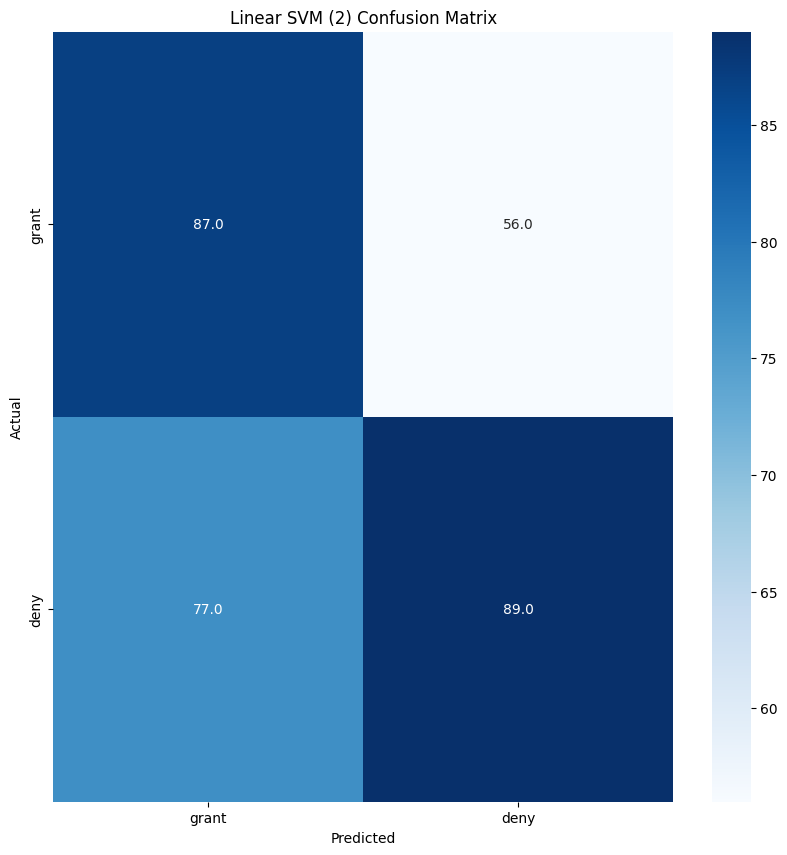

array([[87, 56],
       [77, 89]])

In [144]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC( random_state=42, tol=1e-5)),
])

text_clf.fit(support_train_x, support_train_target)
predicted = text_clf.predict(support_test_x)
print(f"accuracy: {np.mean(predicted == support_test_target)}")


confusion_plot(support_test_target, predicted, classes, labels=labels, normalize=False, title="Linear SVM (2) Confusion Matrix")

0.5275080906148867


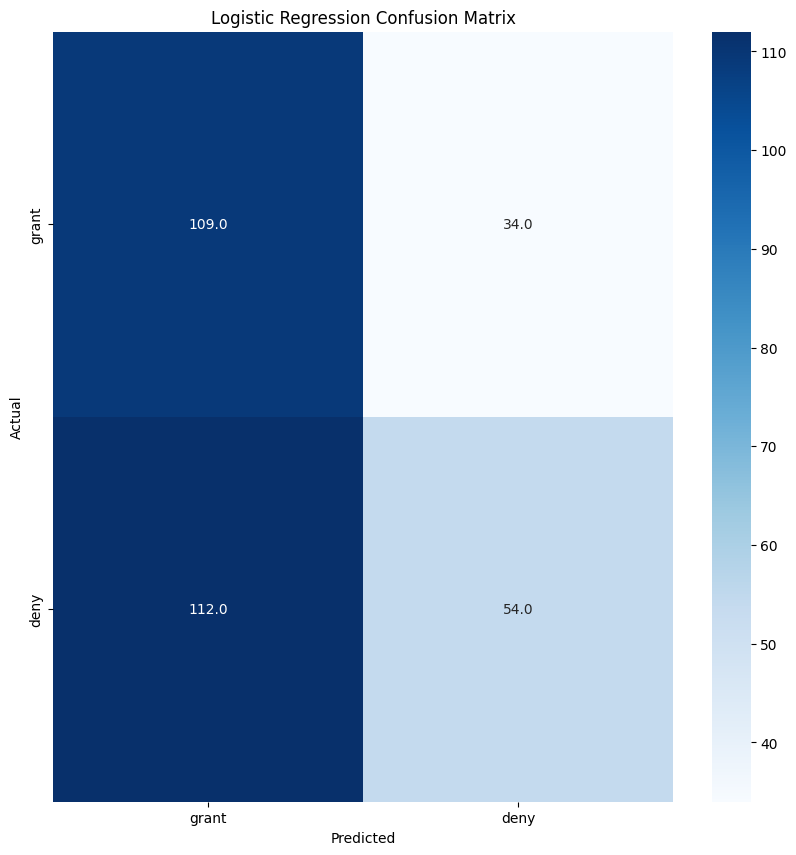

array([[109,  34],
       [112,  54]])

In [155]:

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logistic',LogisticRegression(solver='liblinear')),
])

text_clf.fit(support_train_x, support_train_target)
predicted = text_clf.predict(support_test_x)
print(np.mean(predicted == support_test_target))
#print(f"probability: {text_clf.predict_proba(support_test_x)}")
confusion_plot(support_test_target, predicted, classes, labels=labels, normalize=False, title="Logistic Regression Confusion Matrix")

0.5533980582524272


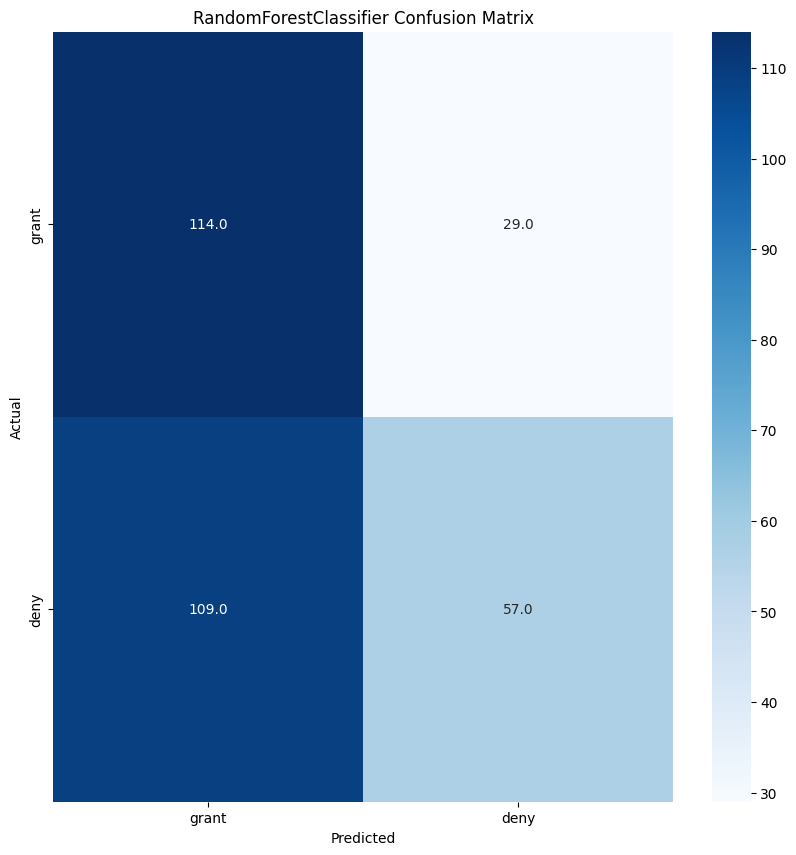

array([[114,  29],
       [109,  57]])

In [6]:

text_rft = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('RFT', RandomForestClassifier(n_estimators = 1500, criterion = "entropy", oob_score = True, max_features= 1)),
])

text_rft.fit(support_train_x, support_train_target)
predicted_rft = text_rft.predict(support_test_x)
print(np.mean(predicted_rft == support_test_target))
#print(f"probability: {text_clf.predict_proba(support_test_x)}")
confusion_plot(support_test_target, predicted_rft, classes, labels=labels, normalize=False, title="RandomForestClassifier Confusion Matrix")



In [9]:
with open('model.pkl', 'wb') as f:  # open a text file
    dump(text_rft, f) 

with open('model.pkl', 'rb') as f:
    new_clf = load(f)

In [10]:
for i in zip(text_rft.predict_proba(support_test_x) , text_rft.predict(support_test_x)):
    print(i)

(array([0.55333333, 0.44666667]), 'deny')
(array([0.49333333, 0.50666667]), 'grant')
(array([0.408, 0.592]), 'grant')
(array([0.53933333, 0.46066667]), 'deny')
(array([0.51, 0.49]), 'deny')
(array([0.478, 0.522]), 'grant')
(array([0.49466667, 0.50533333]), 'grant')
(array([0.52933333, 0.47066667]), 'deny')
(array([0.47333333, 0.52666667]), 'grant')
(array([0.448, 0.552]), 'grant')
(array([0.466, 0.534]), 'grant')
(array([0.42266667, 0.57733333]), 'grant')
(array([0.446, 0.554]), 'grant')
(array([0.45533333, 0.54466667]), 'grant')
(array([0.39666667, 0.60333333]), 'grant')
(array([0.53733333, 0.46266667]), 'deny')
(array([0.45466667, 0.54533333]), 'grant')
(array([0.44533333, 0.55466667]), 'grant')
(array([0.51533333, 0.48466667]), 'deny')
(array([0.43666667, 0.56333333]), 'grant')
(array([0.42733333, 0.57266667]), 'grant')
(array([0.26933333, 0.73066667]), 'grant')
(array([0.538, 0.462]), 'deny')
(array([0.37933333, 0.62066667]), 'grant')
(array([0.47666667, 0.52333333]), 'grant')
(arr

 accuracy 0.540453074433657


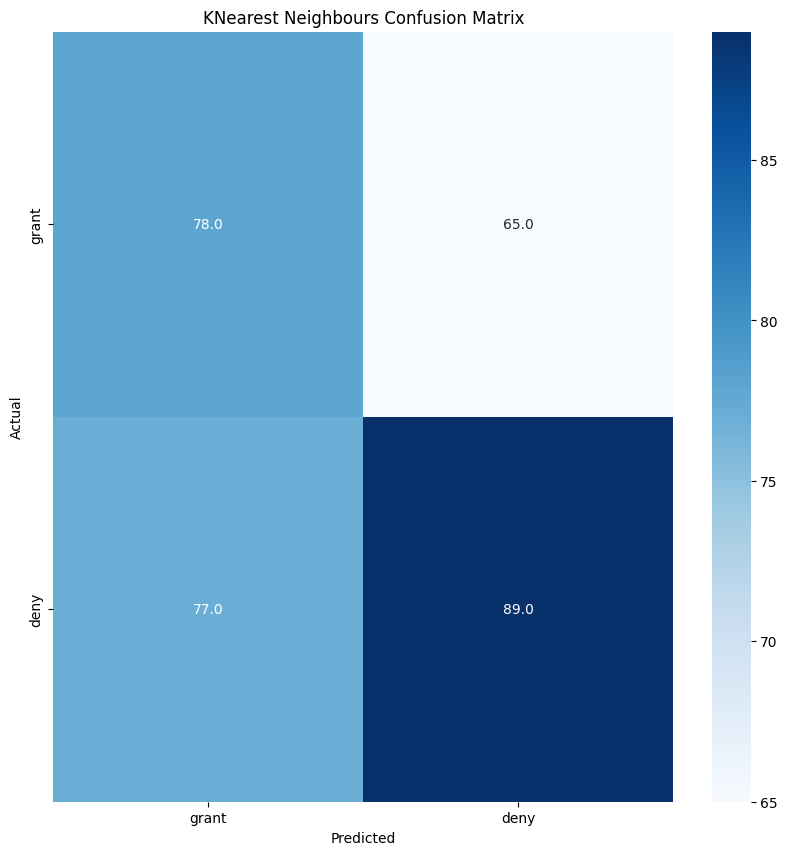

array([[78, 65],
       [77, 89]])

In [154]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('KNN', KNeighborsClassifier()),
])

text_clf.fit(support_train_x, support_train_target)
predicted = text_clf.predict(support_test_x)
print(f" accuracy {np.mean(predicted == support_test_target)}")
confusion_plot(support_test_target, predicted, classes, labels=labels, normalize=False, title="KNearest Neighbours Confusion Matrix")


### Embeddings

This is th Embeddings part of the experiment. Here I train models with embeddings.
I use Hugging faces sentence-transformers embeddinggs

In [8]:
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)
testset['embeddings'] = ""
testset['embeddings'] = testset['prompt'].map(sentence_model.encode)
testset['embeddings']

support_train_x = np.array(testset["embeddings"].loc[(testset["brief_type"]=="support") & (testset["data_type"]=="train") ].to_list())  #  np.array(testset['file_path'].to_list())
opposition_train_x = np.array(testset["embeddings"].loc[(testset["brief_type"]=="opposition") & (testset["data_type"]=="train") ].to_list())  #  np.array(testset['file_path'].to_list())

support_test_x = np.array(testset["embeddings"].loc[(testset["brief_type"]=="support") & (testset["data_type"]=="test") ].to_list())  #  np.array(testset['file_path'].to_list())
opposition_test_x = np.array(testset["embeddings"].loc[(testset["brief_type"]=="opposition") & (testset["data_type"]=="test") ].to_list()) 


support_train_target = np.array( testset["completion"].loc[(testset["brief_type"]=="support") & (testset["data_type"]=="train") ].to_list())  # np.array(testset['label'].to_list())
opposition_train_target=  np.array(testset["completion"].loc[(testset["brief_type"]=="opposition") & (testset["data_type"]=="train") ].to_list())  # np.array(testset['label'].to_list())


support_test_target = np.array( testset["completion"].loc[(testset["brief_type"]=="support") & (testset["data_type"]=="test") ].to_list())  # np.array(testset['label'].to_list())
opposition_test_target =  np.array(testset["completion"].loc[(testset["brief_type"]=="opposition") & (testset["data_type"]=="test") ].to_list()) 

In [9]:
accuracies(support_train_x, support_train_target, support_test_x, support_test_target,feature_type='support-sentence_embeddings')

SGD: 0.0
RFT: 0.0
KNN: 0.0
Logistic: 0.0
LinearSVC: 0.0


/scratchB/oqcardoso/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [11]:
accuracies(opposition_train_x, opposition_train_target, opposition_test_x, opposition_test_target,feature_type='opposition-sentence_embeddings')

SGD: 0.0
RFT: 0.0
KNN: 0.0
Logistic: 0.0
LinearSVC: 0.0


/scratchB/oqcardoso/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


### Combination Deep Sets

https://github.com/dpernes/deepsets-digitsum

https://github.com/manzilzaheer/DeepSets/blob/master/DigitSum/image_sum.ipynb

https://paperswithcode.com/paper/deep-sets

https://github.com/lucidrains/perceiver-pytorch

https://www.youtube.com/watch?v=P_xeshTnPZg

https://paperswithcode.com/method/set-transformer

https://arxiv.org/pdf/1810.00825.pdf

https://arxiv.org/abs/1910.02421

https://arxiv.org/pdf/1703.06114.pdf

https://huggingface.co/docs/transformers/model_doc/perceiver

https://www.youtube.com/watch?v=Xe7VT8-kDzg

https://github.com/krasserm/perceiver-io

https://www.youtube.com/watch?v=YBkOILybiNo

https://www.youtube.com/watch?v=9ymIqU4XnhY

https://paperswithcode.com/paper/set-transformer-a-framework-for-attention#code

https://www.inference.vc/deepsets-modeling-permutation-invariance/

https://medium.com/@albertoarrigoni/paper-review-code-deep-sets-5f87d335f16f

https://medium.com/@albertoarrigoni/paper-review-code-set-transformer-b9750e5c3fdb

https://www.youtube.com/watch?v=wTZ3o36lXoQ&t=199s